# AI-Clinical-Rehab-Platform

## Basic setting

In [ ]:
from pathlib import Path
import pandas as pd
import numpy as np
import schema
from scipy import stats
from scipy.stats import ks_2samp
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import load_model
from tensorflow.keras import layers, models
from glob import glob

## Data Observation

In [ ]:
# 讀取檔案，MHEALTH 主要是用 tab (\t) 或空格分隔
file_path = 'data_raw/mHealth_subject1.log'

# 讀取數據
df = pd.read_csv(file_path, sep='\t', header=None)

# 根據 schema.py 中的定義，提取左踝加速度的 X、Y、Z 軸數據
left_ankle_acc_x = df.iloc[:, schema.MHEALTH_COLUMNS['LEFT_ANKLE_ACC_X']]
left_ankle_acc_y = df.iloc[:, schema.MHEALTH_COLUMNS['LEFT_ANKLE_ACC_Y']]
left_ankle_acc_z = df.iloc[:, schema.MHEALTH_COLUMNS['LEFT_ANKLE_ACC_Z']]
        

# 查看前五筆資料，確認數字是否正確載入
print(df.head())

# ReadMe.txt 中提到，資料集中的數據是以 50Hz 的頻率收集的，這意味著每秒鐘會有 50 筆數據。每筆數據包含了來自不同感測器的讀數，以及對應的動作標籤。
# 建立一個從 0 開始，間隔為 0.02 秒的時間軸
df['timestamp'] = df.index * 0.02

# 偵測左踝加速度 X 軸是否連續無變化
df['left_ankle_acc_x_diff'] = left_ankle_acc_x.diff()

# Magnitude動作週期的「平均震幅 (Magnitude)」
df['left_ankle_mag'] = np.sqrt(left_ankle_acc_x**2 + left_ankle_acc_y**2 + left_ankle_acc_z**2)

       0         1        2         3         4       5       6        7   \
0 -9.8184  0.009971  0.29563  0.004186  0.004186  2.1849 -9.6967  0.63077   
1 -9.8489  0.524040  0.37348  0.004186  0.016745  2.3876 -9.5080  0.68389   
2 -9.6602  0.181850  0.43742  0.016745  0.037677  2.4086 -9.5674  0.68113   
3 -9.6507  0.214220  0.24033  0.079540  0.117220  2.1814 -9.4301  0.55031   
4 -9.7030  0.303890  0.31156  0.221870  0.205130  2.4173 -9.3889  0.71098   

         8        9   ...      14      15        16       17      18  \
0  0.103900 -0.84053  ... -8.6499 -4.5781  0.187760 -0.44902 -1.0103   
1  0.085343 -0.83865  ... -8.6275 -4.3198  0.023595 -0.44902 -1.0103   
2  0.085343 -0.83865  ... -8.5055 -4.2772  0.275720 -0.44902 -1.0103   
3  0.085343 -0.83865  ... -8.6279 -4.3163  0.367520 -0.45686 -1.0082   
4  0.085343 -0.83865  ... -8.7008 -4.1459  0.407290 -0.45686 -1.0082   

         19       20        21        22  23  
0  0.034483 -2.35000 -1.610200 -0.030899   0  
1  0.03448

## Risk Analysis (ISO 14971)

- 風險名稱： 數據通道偏移 (Field Offset Risk)
- 風險描述： 在開發或配置過程中，由於感測器欄位索引定義錯誤（例如誤將磁力計數據通道當作加速度計），導致系統獲取錯誤的物理量進行運算。
- 潛在臨床危害： 產生誤導性的加速度數據，可能導致系統對病患的運動強度評估錯誤，甚至在跌倒偵測功能中產生偽陽性（False Positive）警報，引發醫療介入錯誤。
- 緩解措施 (Mitigation)：
    1. 數據合理性檢查 (Sanity Check)： 驗證靜止狀態下的數據是否符合重力常數（約 $9.8 m/s^2$）。
    2. 物理極限門檻： 設定人體運動加速度上限（$50 m/s^2$），超過此門檻則視為異常數據並予以攔截。

In [3]:
# 驗證數據品質
def validate(label_id):
    avg_mag = df[df.iloc[:, 23] == label_id]['left_ankle_mag'].mean()
    limit = schema.PHYSICAL_CONSTANTS['ACC_ERROR_THRESHOLD']    # ACC_ERROR_THRESHOLD 是一個合理的加速度極限值，目前設定為50，根據實際情況調整
    if np.isnan(avg_mag):
        print(f"警告：{schema.ACTIVITY_LABELS[label_id]} 沒有數據可用來驗證！")
    elif avg_mag < 0:
        print(f"錯誤：{schema.ACTIVITY_LABELS[label_id]} 數據有負值，可能存在錯誤！")
    elif avg_mag > 2 * schema.PHYSICAL_CONSTANTS['GRAVITY']:
        print(f"錯誤：{schema.ACTIVITY_LABELS[label_id]} 數據異常高，可能存在錯誤！")
    elif avg_mag < 0.1 * schema.PHYSICAL_CONSTANTS['GRAVITY']:
        print(f"錯誤：{schema.ACTIVITY_LABELS[label_id]} 數據異常低，可能存在錯誤！")
    elif avg_mag > limit:
        print(f"錯誤：{schema.ACTIVITY_LABELS[label_id]} 數據超過極限！")
    elif label_id == 1 and (avg_mag < 9.0 or avg_mag > 11.0):
        print(f"警告：{schema.ACTIVITY_LABELS[label_id]} 數據偏低，可能需要進一步檢查！")
    elif label_id == 4 and avg_mag < 11.0:
        print(f"警告：{schema.ACTIVITY_LABELS[label_id]} 數據偏低，可能需要進一步檢查！")
    else:
        print(f"成功：{schema.ACTIVITY_LABELS[label_id]} 均值為 {avg_mag:.2f}，驗證通過。")

validate(1)
validate(4)

成功：Standing Still 均值為 9.83，驗證通過。
成功：Walking 均值為 13.98，驗證通過。


## Data Observation

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161280 entries, 0 to 161279
Data columns (total 27 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   0                      161280 non-null  float64
 1   1                      161280 non-null  float64
 2   2                      161280 non-null  float64
 3   3                      161280 non-null  float64
 4   4                      161280 non-null  float64
 5   5                      161280 non-null  float64
 6   6                      161280 non-null  float64
 7   7                      161280 non-null  float64
 8   8                      161280 non-null  float64
 9   9                      161280 non-null  float64
 10  10                     161280 non-null  float64
 11  11                     161280 non-null  float64
 12  12                     161280 non-null  float64
 13  13                     161280 non-null  float64
 14  14                     161280 non-nu

In [44]:
df.isnull().sum()

0                        0
1                        0
2                        0
3                        0
4                        0
5                        0
6                        0
7                        0
8                        0
9                        0
10                       0
11                       0
12                       0
13                       0
14                       0
15                       0
16                       0
17                       0
18                       0
19                       0
20                       0
21                       0
22                       0
23                       0
timestamp                0
left_ankle_acc_x_diff    1
left_ankle_mag           0
dtype: int64

In [4]:
print("Label 1 (Standing) Average Magnitude:",df[df.iloc[:, 23]  == 1]['left_ankle_mag'].mean())
print("Label 4 (Walking) Average Magnitude:", df[df.iloc[:, 23] == 4]['left_ankle_mag'].mean())

Label 1 (Standing) Average Magnitude: 9.83418920121884
Label 4 (Walking) Average Magnitude: 13.9838098985216


In [5]:
# 比較 Label 4 (Walking) 、 Label 11 (Running) 的標準差、離散係數（Coefficient of Variation, CV）。
print("Label 4 (Walking) Average Magnitude:", df[df.iloc[:, 23] == 4]['left_ankle_mag'].mean())
print("Label 4 (Walking) Standard Deviation:", df[df.iloc[:, 23] == 4]['left_ankle_mag'].std())
print("Label 4 (Walking) CV:", df[df.iloc[:, 23] == 4]['left_ankle_mag'].std() / df[df.iloc[:, 23] == 4]['left_ankle_mag'].mean() if df[df.iloc[:, 23] == 4]['left_ankle_mag'].mean() != 0 else 0)
print("Label 10 (Running) Average Magnitude:", df[df.iloc[:, 23] == 10]['left_ankle_mag'].mean())
print("Label 10 (Running) Standard Deviation:", df[df.iloc[:, 23] == 10]['left_ankle_mag'].std())
print("Label 10 (Running) CV:", df[df.iloc[:, 23] == 10]['left_ankle_mag'].std() / df[df.iloc[:, 23] == 10]['left_ankle_mag'].mean() if df[df.iloc[:, 23] == 10]['left_ankle_mag'].mean() != 0 else 0)
print("Label 11 (Running) Average Magnitude:", df[df.iloc[:, 23] == 11]['left_ankle_mag'].mean())
print("Label 11 (Running) Standard Deviation:", df[df.iloc[:, 23] == 11]['left_ankle_mag'].std())
print("Label 11 (Running) CV:", df[df.iloc[:, 23] == 11]['left_ankle_mag'].std() / df[df.iloc[:, 23] == 11]['left_ankle_mag'].mean() if df[df.iloc[:, 23] == 11]['left_ankle_mag'].mean() != 0 else 0)

Label 4 (Walking) Average Magnitude: 13.9838098985216
Label 4 (Walking) Standard Deviation: 5.597324281779596
Label 4 (Walking) CV: 0.40027176587772106
Label 10 (Running) Average Magnitude: 17.448713105060317
Label 10 (Running) Standard Deviation: 6.79843850366702
Label 10 (Running) CV: 0.3896240635474371
Label 11 (Running) Average Magnitude: 20.2209344181781
Label 11 (Running) Standard Deviation: 8.561763210323438
Label 11 (Running) CV: 0.4234108589277968


## 滑動視窗實作函數

In [5]:
def create_sliding_windows(df, window_size=128, overlap=64):
# 1. 初始化容器
    X = []
    y = []

    # 2. 從 schema 取得特徵與標籤的索引
    # 我們選取左腳踝的三軸加速度作為特徵
    feature_indices = [
        schema.MHEALTH_COLUMNS['LEFT_ANKLE_ACC_X'],
        schema.MHEALTH_COLUMNS['LEFT_ANKLE_ACC_Y'],
        schema.MHEALTH_COLUMNS['LEFT_ANKLE_ACC_Z']
    ]
    label_index = schema.MHEALTH_COLUMNS['LABEL']

    # 3. 為了效能，將 DataFrame 轉為 Numpy Array
    data_values = df.values

    # 4. 開始滑動視窗迴圈
    # 從 0 開始，每次移動 overlap 的距離 (64 點)
    for i in range(0, len(data_values) - window_size, overlap):
        # 擷取當前視窗的特徵數據 (128, 3)
        window_features = data_values[i : i + window_size, feature_indices]

        # 擷取當前視窗的所有標籤
        window_labels = data_values[i : i + window_size, label_index]
        
        # 5. 標籤處理邏輯：取眾數 (Majority Vote)
        # 找出這 128 點中最常出現的動作標籤
        mode_result = stats.mode(window_labels, keepdims=True)
        majority_label = int(mode_result.mode[0])
        
        # 6. 過濾機制：排除標籤 0 (無效數據)
        if majority_label != 0:
            X.append(window_features)
            y.append(majority_label)
            
    # 7. 轉換為 Numpy 格式並回傳
    return np.array(X), np.array(y)

In [37]:
# --- 執行切割任務 ---
print("正在執行滑動視窗切割 (Window: 128, Overlap: 64)...")
X_train, y_train = create_sliding_windows(df)
print(X_train)
#--- 最終檢查點 ---
print("✅ 切割任務完成！")
print("特徵數據形狀 (樣本數, 時間步, 軸數):", X_train.shape)
print("標籤數據形狀:", y_train.shape)
print("動作類別分佈:", np.unique(y_train, return_counts=True))



正在執行滑動視窗切割 (Window: 128, Overlap: 64)...
[[[  2.6493   -9.4517    0.37683]
  [  2.4157   -9.5306    0.40179]
  [  2.3865   -9.5991    0.48141]
  ...
  [  2.3661   -9.5691    0.51396]
  [  2.3724   -9.3531    0.33732]
  [  2.3862   -9.5794    0.47197]]

 [[  2.2228   -9.5296    0.50408]
  [  2.4691   -9.7682    0.41128]
  [  2.2212   -9.5013    0.37007]
  ...
  [  2.2009   -9.4311    0.45671]
  [  2.4893   -9.4784    0.67597]
  [  2.4488   -9.5181    0.66316]]

 [[  2.3443   -9.4005    0.543  ]
  [  2.4364   -9.5103    0.4551 ]
  [  2.4453   -9.5416    0.29737]
  ...
  [  2.4261   -9.6104    0.34582]
  [  2.457    -9.4501    0.53123]
  [  2.3863   -9.5693    0.49331]]

 ...

 [[ -0.88817  -5.4813   -6.5434 ]
  [ -0.81251  -5.4773   -7.1362 ]
  [ -0.54547  -5.6459   -8.1523 ]
  ...
  [  2.4094   -9.5772   -1.2881 ]
  [  3.5078   -9.3309   -1.4106 ]
  [  3.7555   -9.0184   -1.8404 ]]

 [[ -1.2346  -17.298    -6.0648 ]
  [ -0.7924  -14.015    -5.5004 ]
  [  1.8307  -13.296    -8.7923 ]
  .

### 539的來源：

Data總共161280筆，並經過切割及挑選：

1. 數據的重複利用 (Overlap)
因為我們設定了 Overlap = 64，這代表數據是被「重複使用」的。

- 片段 1：第 1 點到第 128 點。

- 片段 2：第 65 點到第 192 點（中間 64 點是重複的）。

邏輯：這就像你在影印文件時，每一頁都故意多印上一頁最後的一段話，確保內容不會因為翻頁而斷掉。

2. 被丟進垃圾桶的數據 (Label 0)
這是造成 539 這個數字最主要的原因。

- 原始數據狀態：在 MHEALTH 的 161,280 筆數據中，有非常大比例的標籤是 0。

- Label 0 是什麼？：它代表「無效動作」、「感測器重啟中」或是「受試者在休息」。

- 過濾邏輯：你在程式碼中寫了 if majority_label != 0。這行指令就像一個過濾網，把所有標籤為 0 的片段全部丟掉了。

- 結果：在那 161,280 筆中，雖然我們切出了約 2519 個原始視窗，但其中約 1980 個視窗都是 Label 0 (沒意義的動作)，最後只有 539 個視窗是真正有意義的復健動作（Label 1~12）。



## 1D-CNN 模型建構

### 1. 建構model

In [ ]:
def build_clinical_cnn_model(input_shape=(128, 3), num_classes=12):
# 1. 建立空模型容器
    model = models.Sequential()

    # 2. 第一層卷積 (Conv1D)：自動掃描波形特徵
    # filters=64 代表我們用 64 個不同的濾波器去尋找圖案
    # kernel_size=3 代表掃描器一次看 3 個時間點的關聯
    model.add(layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape))

    # 3. 第二層卷積：深化特徵提取
    model.add(layers.Conv1D(filters=64, kernel_size=3, activation='relu'))

    # 4. 丟棄層 (Dropout)：防止過擬合 (Overfitting)
    # 隨機關閉 50% 的神經元，讓模型更具魯棒性，不會只死背考古題
    model.add(layers.Dropout(0.5))

    # 5. 池化層 (MaxPooling)：摘要關鍵訊號
    # 將數據減半，只保留該區段最強的動作訊號
    model.add(layers.MaxPooling1D(pool_size=2))

    # 6. 平坦化 (Flatten)：將空間特徵轉為一維陣列
    model.add(layers.Flatten())

    # 7. 全連接層 (Dense)：進行邏輯推理
    model.add(layers.Dense(100, activation='relu'))

    # 8. 輸出層 (Output)：給出 12 個動作的機率分布
    # 使用 softmax 確保 12 個動作的機率總和等於 1
    model.add(layers.Dense(num_classes + 1, activation='softmax'))

    # 9. 模型編譯 (Compile)：定義學習規則
    # 使用 adam 優化器與 sparse_categorical_crossentropy 損失函數
    model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
    return model

In [10]:
my_brain = build_clinical_cnn_model()
my_brain.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 126, 64)        │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 124, 64)        │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 124, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 62, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 3968)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │       396,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 13)             │         1,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 411,205 (1.57 MB)

 Trainable params: 411,205 (1.57 MB)

 Non-trainable params: 0 (0.00 B)

### 2. 開始訓練 (Model Training)
- epochs=50 代表讓 AI 把這 539 段數據重複讀 50 遍
- validation_split=0.2 代表我們偷偷藏起 20% 的數據不讓它看答案，用來當作期末考題
- batch_size=32 代表一次餵 32 段數據給它，比較不佔記憶體


In [22]:
X_train, X_val, y_train, y_val = train_test_split(
X_train,
y_train,
test_size=0.2,    # 切出 20% 當作驗證集
random_state=42,  # 固定隨機種子，確保每次切出來的題號都一樣
stratify=y_train  # 重要：確保每一種動作在兩邊的比例都一樣
)

In [23]:
print("🚀 引擎啟動，開始訓練...")
history = my_brain.fit(
X_train, y_train,
epochs=50,
batch_size=32,
validation_data = (X_val, y_val),
verbose=1
)

🚀 引擎啟動，開始訓練...
Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7471 - loss: 2.1118 - val_accuracy: 0.6852 - val_loss: 0.9170
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9002 - loss: 0.3880 - val_accuracy: 0.9259 - val_loss: 0.3006
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9930 - loss: 0.0927 - val_accuracy: 0.9722 - val_loss: 0.1423
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9954 - loss: 0.0315 - val_accuracy: 0.9630 - val_loss: 0.1118
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9907 - loss: 0.0337 - val_accuracy: 0.9722 - val_loss: 0.0926
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - loss: 0.0089 - val_accuracy: 0.9815 - val_loss: 0.0808
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 1.0000 - loss: 0.0046 - val_accuracy: 0.9722 - val_loss: 0.0651
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9977 - loss: 0.0057 - val_accur

### 3. 繪製訓練結果圖表 (Plotting)

In [24]:
# 看準確度 (Accuracy) 與 損失 (Loss) 的變化
plt.figure(figsize=(12, 4))

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

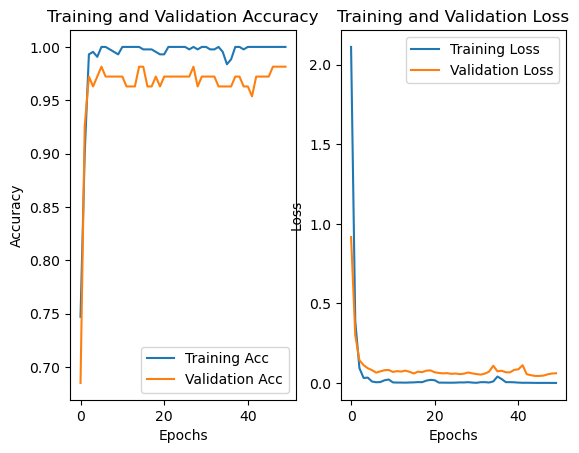

In [25]:
# 準確度圖 (Accuracy)
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Acc')
plt.plot(history.history['val_accuracy'], label='Validation Acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# 損失圖 (Loss)
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()
# Eochs = 50 代表model訓練的次數(完整讀完所有訓練數據的次數)

### 4. 模型存檔
- 目的： 將你辛苦訓練 50 輪的 41 萬個參數存檔。在 SaMD (醫療器材軟體) 開發中，這代表了專案的「版本 V1.0」。
- 將模型儲存為標準 Keras 格式，檔案名稱建議加上版本號，方便日後追蹤。


In [26]:
my_brain.save('clinical_rehab_model_v1.keras')
print("✅ 模型 V1.0 已成功存檔為 'clinical_rehab_model_v1.keras'")
print("這代表你的大腦參數已經被永久保存，Day 6 我們可以直接載入使用。")

✅ 模型 V1.0 已成功存檔為 'clinical_rehab_model_v1.keras'
這代表你的大腦參數已經被永久保存，Day 6 我們可以直接載入使用。


### 5.單一樣本預測測試 (Prediction Test)
目的： 驗證模型輸出形狀是否符合預期。即使準確率現在很低，我們也要確保「出水口」是通的。
1. 從教材中隨機抓取「一個」動作片段 (形狀需為 1, 128, 3)
2. 讓 AI 進行預測
3. 觀察結果


In [27]:
sample_to_test = X_train[0:1]
raw_prediction = my_brain.predict(sample_to_test)
print("\n--- AI 預測測試報告 ---")
print("輸入形狀：", sample_to_test.shape)
print("輸出形狀：", raw_prediction.shape) # 預期應為 (1, 13)
print("各類別機率分佈：\n", np.round(raw_prediction, 3))
print("機率最高之類別索引：", np.argmax(raw_prediction))
print("正確標籤答案：", y_train[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

--- AI 預測測試報告 ---
輸入形狀： (1, 128, 3)
輸出形狀： (1, 13)
各類別機率分佈：
 [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]
機率最高之類別索引： 6
正確標籤答案： 6


## Confusion Matrix

| | 預測為 Positive (AI 猜是) | 預測為 Negative (AI 猜不是) |
| :--- | :---: | :---: |
| **真實為 Positive (實際上是)** | **TP** <br>(True Positive) | **FN** <br>(False Negative) |
| **真實為 Negative (實際不是)** | **FP** <br>(False Positive) | **TN** <br>(True Negative) |

### 📈 臨床性能指標公式

* **精確率 (Precision)** = $TP / (TP + FP)$
    * *解讀：AI 喊出該動作時，有多少機率喊對？（正確命中：猜測為真的案例中，實際有多少案為真）*
* **召回率 (Recall)** = $TP / (TP + FN)$
    * *解讀：所有的該動作中，AI 成功抓到了多少？（偵測率/捕獲率：實際為真的案例中，答對多少）*
* **F1-Score** = $2 \times (Precision \times Recall) / (Precision + Recall)$
    * *解讀：綜合考量 TP、FP、FN 的平衡分數。*

🔍 正在對驗證集進行診斷...
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


c:\Users\freea\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 23526 (\N{CJK UNIFIED IDEOGRAPH-5BE6}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\freea\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 38555 (\N{CJK UNIFIED IDEOGRAPH-969B}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\freea\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 21205 (\N{CJK UNIFIED IDEOGRAPH-52D5}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\freea\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20316 (\N{CJK UNIFIED IDEOGRAPH-4F5C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\freea\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 29468 (\N{CJK UNIFIED IDEOGRAPH-731C}) missing from font(s) DejaVu San

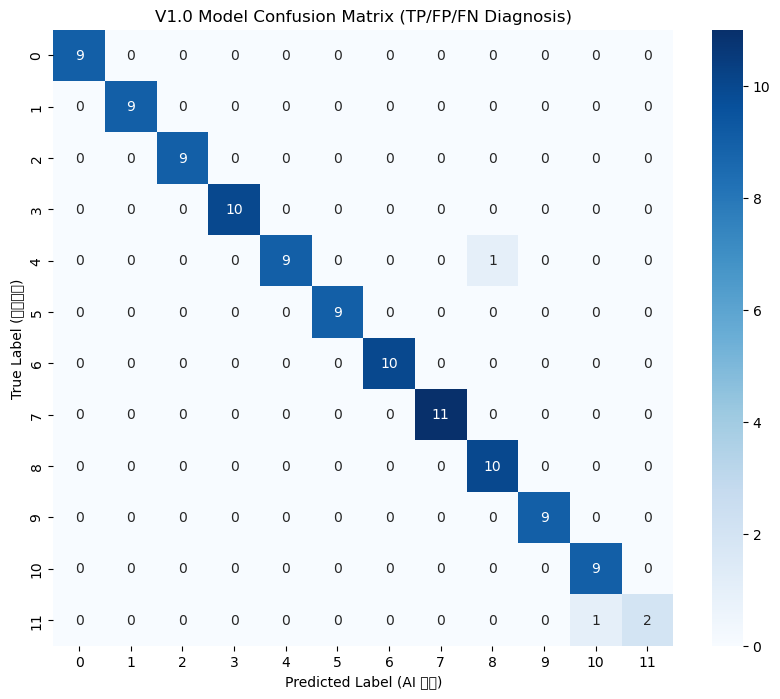


--- 臨床性能指標報告 (Classification Report) ---
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00         9
           3       1.00      1.00      1.00         9
           4       1.00      1.00      1.00        10
           5       1.00      0.90      0.95        10
           6       1.00      1.00      1.00         9
           7       1.00      1.00      1.00        10
           8       1.00      1.00      1.00        11
           9       0.91      1.00      0.95        10
          10       1.00      1.00      1.00         9
          11       0.90      1.00      0.95         9
          12       1.00      0.67      0.80         3

    accuracy                           0.98       108
   macro avg       0.98      0.96      0.97       108
weighted avg       0.98      0.98      0.98       108



In [28]:
model = load_model('clinical_rehab_model_v1.keras')
# 2. 進行預測 (對驗證集進行大考驗)    注意：這裡我們使用昨天切分出的 20% 驗證集數據 (X_val)
print("🔍 正在對驗證集進行診斷...")
y_pred_probs = model.predict(X_val)
y_pred = np.argmax(y_pred_probs, axis=1)

# 3. 繪製混淆矩陣 (Confusion Matrix) 熱力圖
cm = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('V1.0 Model Confusion Matrix (TP/FP/FN Diagnosis)')
plt.ylabel('True Label (實際動作)')
plt.xlabel('Predicted Label (AI 猜測)')
plt.show()

#4. 產出詳細分類報告 (包含 Precision, Recall, F1)    這裡會幫你算出每一類動作的 TP, FP, FN 比例
print("\n--- 臨床性能指標報告 (Classification Report) ---")
report = classification_report(y_val, y_pred)
print(report)

## V2.0 輕量化模型
1. **執行 V2.0 代碼**：建立一個減少觀察員（Filters=32）且大幅削減投票員（Dense=16）的模型。
2. **觀察參數變化**：親自執行 brain_v2.summary()，確認 Total params 是否降到了 5 萬 左右。
3. **重新訓練與測試**：觀察 V2.0 的訓練曲線（Accuracy/Loss），看它在數據量同樣少的情況下，過擬合現象是否有所緩解。

In [ ]:
# --- Day 7: V2.0 輕量化大腦實作 ---
brain_v2 = models.Sequential([
    # 觀察員砍半 (64 -> 32)
    layers.Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(128, 3)),
    layers.MaxPooling1D(pool_size=2),
    
    layers.Flatten(),
    
    # 投票員大精簡 (100 -> 16)，這是最核心的優化
    layers.Dense(16, activation='relu'), 
    layers.Dropout(0.5), # 強化紀律
    
    layers.Dense(13, activation='softmax') 
])

# 1. 檢查新的參數規模
brain_v2.summary()

# 2. 開始訓練 (記得使用我們 Day 6 準備好的 X_train, X_val)
history_v2 = brain_v2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# 執行訓練...

c:\Users\freea\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)               │ (None, 126, 32)        │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 63, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 2016)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │        32,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 13)             │           221 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,813 (128.18 KB)

 Trainable params: 32,813 (128.18 KB)

 Non-trainable params: 0 (0.00 B)

### V2.0 訓練與視覺化診斷

🚀 V2.0 精實大腦訓練啟動...
Epoch 1/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.1429 - loss: 2.5978 - val_accuracy: 0.2593 - val_loss: 2.2476
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1967 - loss: 2.3330 - val_accuracy: 0.2778 - val_loss: 2.1631
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2709 - loss: 2.1818 - val_accuracy: 0.3611 - val_loss: 2.0208
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2690 - loss: 2.1599 - val_accuracy: 0.4259 - val_loss: 1.8911
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2579 - loss: 2.0712 - val_accuracy: 0.3981 - val_loss: 1.8288
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2709 - loss: 2.0208 - val_accuracy: 0.4444 - val_loss: 1.7624
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2616 - loss: 2.0627 - val_accuracy: 0.4537 - val_loss: 1.7419
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2820 - loss: 1.9953 - val_accuracy

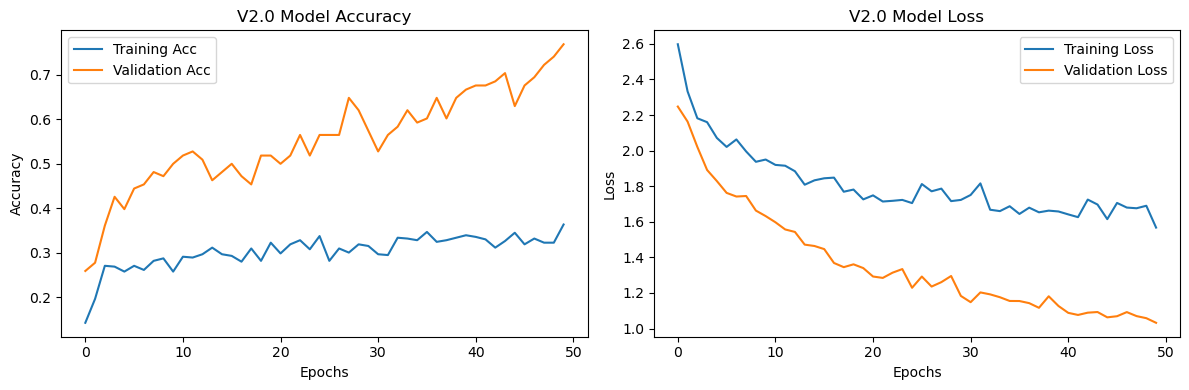

In [ ]:
# 1. 編譯模型：設定優化器與損失函數
brain_v2.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 2. 開始訓練：請 AI 讀這 539 頁教科書 50 遍
print("🚀 V2.0 精實大腦訓練啟動...")
history_v2 = brain_v2.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val), # 使用 Day 6 切好的考卷
    verbose=1
)

# 3. 繪製訓練結果圖表
plt.figure(figsize=(12, 4))

# 準確率圖 (Accuracy)
plt.subplot(1, 2, 1)
plt.plot(history_v2.history['accuracy'], label='Training Acc')
plt.plot(history_v2.history['val_accuracy'], label='Validation Acc')
plt.title('V2.0 Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# 損失圖 (Loss)
plt.subplot(1, 2, 2)
plt.plot(history_v2.history['loss'], label='Training Loss')
plt.plot(history_v2.history['val_loss'], label='Validation Loss')
plt.title('V2.0 Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## V3.0 調整模型
**執行 V3.0 代碼**：建立一個減少觀察員（Filters=32）且調整投票員（Dense=64）的模型。

In [ ]:
# --- Day 7: V3.0  ---
brain_v3 = models.Sequential([
    # 觀察員砍半 (64 -> 32)
    layers.Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(128, 3)),
    layers.MaxPooling1D(pool_size=2),
    
    layers.Flatten(),
    
    # 投票員大精簡 (100 -> 64)，這是最核心的優化
    layers.Dense(64, activation='relu'), 
    layers.Dropout(0.5), # 強化紀律
    
    layers.Dense(13, activation='softmax') 
])

# 1. 檢查新的參數規模
brain_v3.summary()



Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_8 (Conv1D)               │ (None, 126, 32)        │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 63, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 2016)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │       129,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 13)             │           845 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 130,253 (508.80 KB)

 Trainable params: 130,253 (508.80 KB)

 Non-trainable params: 0 (0.00 B)

### V3.0 訓練與視覺化診斷

🚀 V3.0 ...
Epoch 1/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8173 - loss: 0.4525 - val_accuracy: 0.8972 - val_loss: 0.2656
Epoch 2/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8166 - loss: 0.4547 - val_accuracy: 0.8972 - val_loss: 0.2887
Epoch 3/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8247 - loss: 0.4464 - val_accuracy: 0.8877 - val_loss: 0.2778
Epoch 4/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8261 - loss: 0.4159 - val_accuracy: 0.8906 - val_loss: 0.2546
Epoch 5/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8247 - loss: 0.4169 - val_accuracy: 0.8934 - val_loss: 0.2825
Epoch 6/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8354 - loss: 0.3883 - val_accuracy: 0.9039 - val_loss: 0.2675
Epoch 7/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8235 - loss: 0.4216 - val_accuracy: 0.8792 - val_loss: 0.3028
Epoch 8/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8328 - loss: 0.4208 - val_a

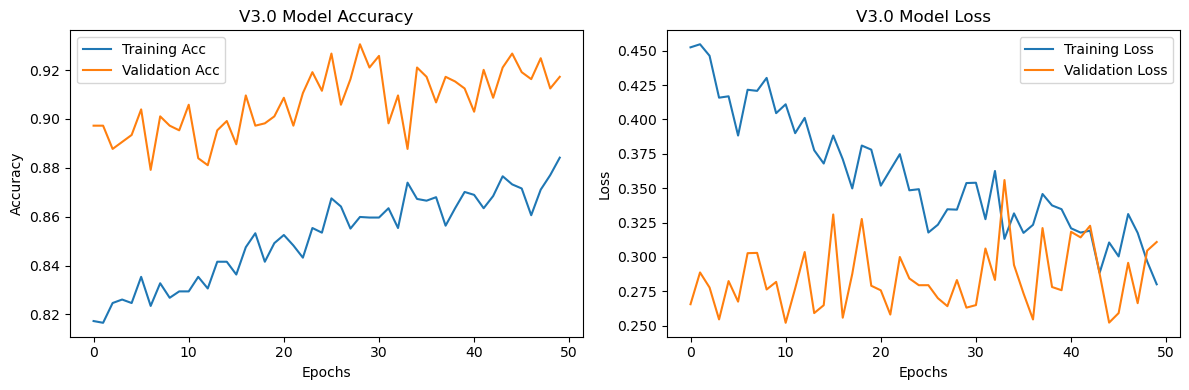

In [54]:

# 2. 開始訓練 (記得使用我們 Day 6 準備好的 X_train, X_val)
history_v3 = brain_v3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 2. 開始訓練：請 AI 讀這 539 頁教科書 50 遍
print("🚀 V3.0 ...")
history_v3 = brain_v3.fit(
    X_train, y_train,
    epochs = 50,
    batch_size = 32,
    validation_data=(X_val, y_val), # 使用 Day 6 切好的考卷
    verbose=1
)



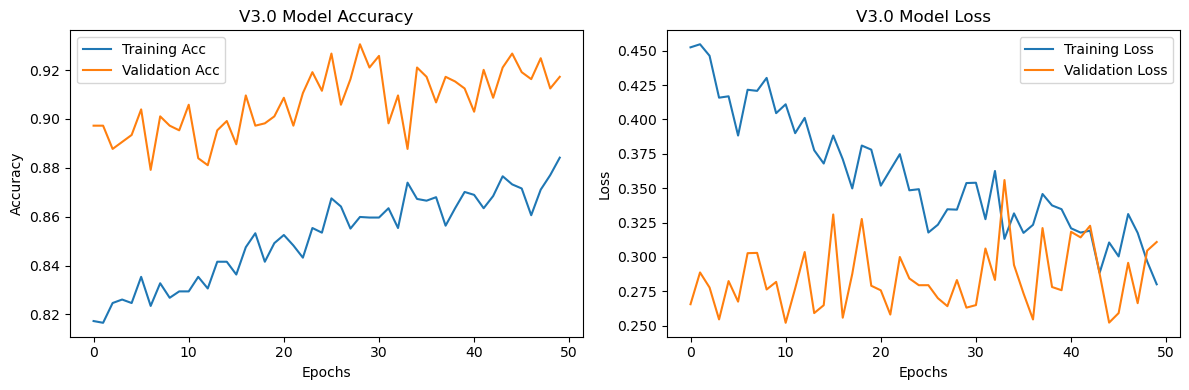

In [57]:
# 3. 繪製訓練結果圖表
plt.figure(figsize=(12, 4))

# 準確率圖 (Accuracy)
plt.subplot(1, 2, 1)
plt.plot(history_v3.history['accuracy'], label='Training Acc')
plt.plot(history_v3.history['val_accuracy'], label='Validation Acc')
plt.title('V3.0 Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# 損失圖 (Loss)
plt.subplot(1, 2, 2)
plt.plot(history_v3.history['loss'], label='Training Loss')
plt.plot(history_v3.history['val_loss'], label='Validation Loss')
plt.title('V3.0 Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## 增加樣本

In [48]:
# 先分開切片，再統一合體
file_list = glob('data_raw/*.log')
all_X = []
all_y = []

for i in file_list:
    df = pd.read_csv(i, sep='\t', header=None)
    X_sub, y_sub = create_sliding_windows(df)
    all_X.append(X_sub)
    all_y.append(y_sub)
X_final = np.concatenate(all_X, axis=0)
y_final = np.concatenate(all_y, axis=0)


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
X_final, y_final, test_size=0.2, random_state=42, stratify=y_final
)

print("訓練集資料筆數：", len(X_train))
print("驗證集資料筆數：", len(X_val))

brain_v3.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("開始進行跨受試者大數據訓練...")
history_v3_multi = brain_v3.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    verbose=1
)

訓練集資料筆數： 4204
驗證集資料筆數： 1051
開始進行跨受試者大數據訓練...
Epoch 1/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8744 - loss: 0.3184 - val_accuracy: 0.9315 - val_loss: 0.2668
Epoch 2/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8777 - loss: 0.3039 - val_accuracy: 0.9334 - val_loss: 0.2714
Epoch 3/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8804 - loss: 0.2944 - val_accuracy: 0.9087 - val_loss: 0.4004
Epoch 4/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8853 - loss: 0.2847 - val_accuracy: 0.9382 - val_loss: 0.2896
Epoch 5/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8837 - loss: 0.2868 - val_accuracy: 0.9248 - val_loss: 0.3902
Epoch 6/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8827 - loss: 0.2796 - val_accuracy: 0.9296 - val_loss: 0.2979
Epoch 7/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8837 - loss: 0.2792 - val_accuracy: 0.9286 - val_loss: 0.2841
Epoch 8/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accu

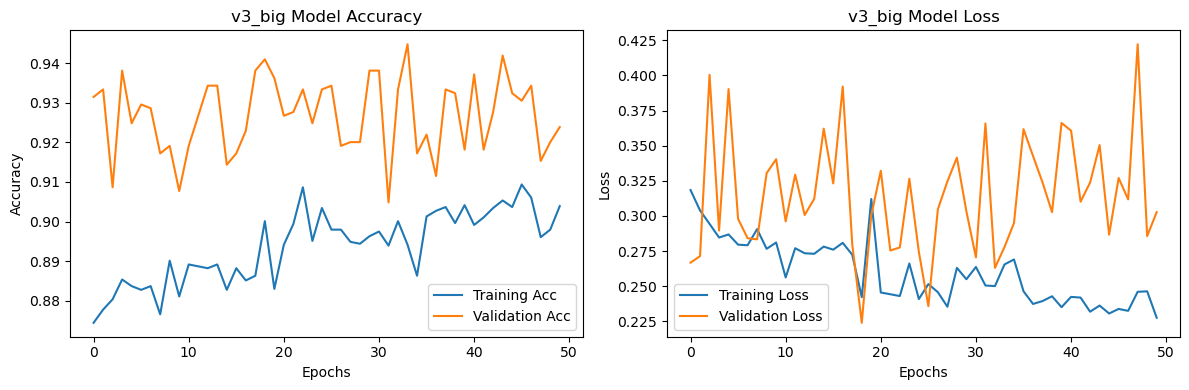

In [ ]:
# 3. 繪製訓練結果圖表
plt.figure(figsize=(12, 4))

# 準確率圖 (Accuracy)
plt.subplot(1, 2, 1)
plt.plot(history_v3_multi.history['accuracy'], label='Training Acc')
plt.plot(history_v3_multi.history['val_accuracy'], label='Validation Acc')
plt.title('v3_multi Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# 損失圖 (Loss)
plt.subplot(1, 2, 2)
plt.plot(history_v3_multi.history['loss'], label='Training Loss')
plt.plot(history_v3_multi.history['val_loss'], label='Validation Loss')
plt.title('v3_multi Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
混淆矩陣圖表已儲存為 confusion_matrix_v3_big.png


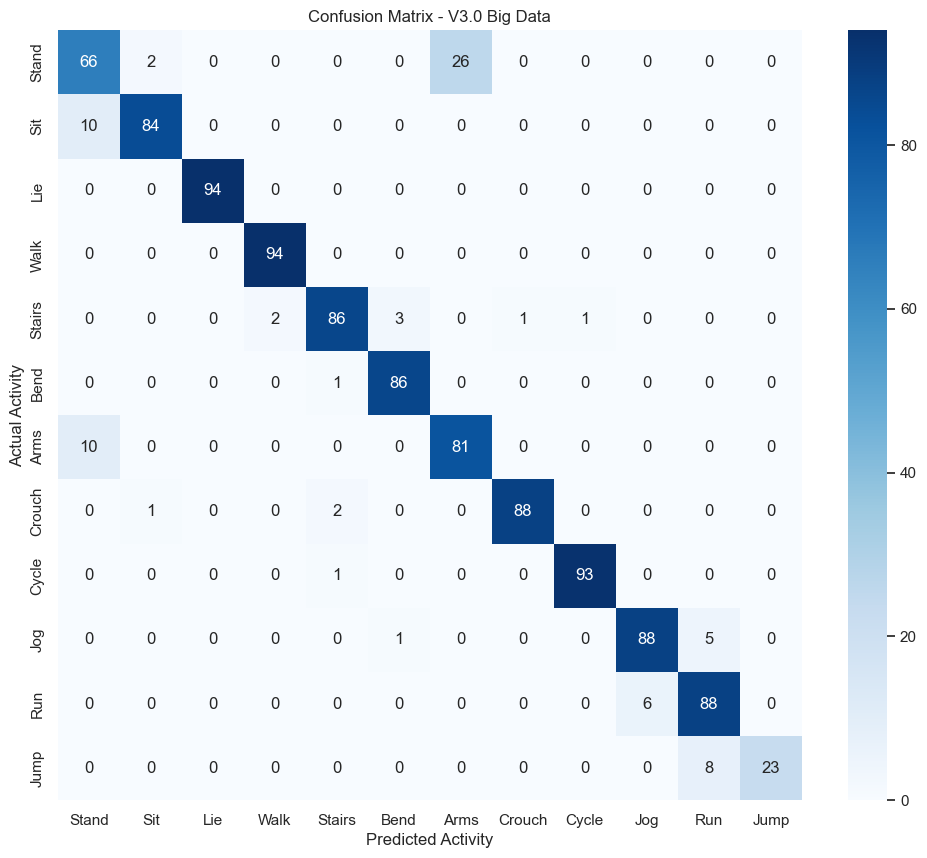

In [ ]:
# 1.　取得模型的預測結果，這裡會對驗證集 X_val 進行預測，並用 argmax 找出機率最高的標籤
y_pred_probs = brain_v3.predict(X_val)
y_pred = np.argmax(y_pred_probs, axis=1)

# 2. 計算混淆矩陣，指定標籤範圍為 1 到 12，對應 MHEALTH 的 12 種有效動作
cm = confusion_matrix(y_val, y_pred, labels=range(1, 13))

#3. 定義動作名稱清單（供圖表標籤使用）
action_names = [
'Stand', 'Sit', 'Lie', 'Walk', 'Stairs',
'Bend', 'Arms', 'Crouch', 'Cycle',
'Jog', 'Run', 'Jump'

]
# 4. 繪製熱圖 (Heatmap)，注意：為了符合規範，不使用 .figure()，直接使用 sns 繪圖並儲存
sns.set(rc={'figure.figsize':(12, 10)})
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
xticklabels=action_names, yticklabels=action_names)
plt.title('Confusion Matrix - V3.0 Big Data')
plt.ylabel('Actual Activity')
plt.xlabel('Predicted Activity')

# 5. 儲存結果圖檔
plt.savefig('confusion_matrix_v3_multi.png')
print("混淆矩陣圖表已儲存為 confusion_matrix_v3_multi.png")

In [59]:
from sklearn.metrics import classification_report

# 6. 產生詳細的分類報告 (包含 Precision, Recall, F1-score)，針對標籤 1 到 12 進行分析
report = classification_report(
y_val,
y_pred,
target_names=action_names,
labels=range(1, 13)
)

# 7. 直接印出結果
print("=== V3.0 十人份大數據：各動作詳細辨識指標報告 ===")
print(report)


=== V3.0 十人份大數據：各動作詳細辨識指標報告 ===
              precision    recall  f1-score   support

       Stand       0.77      0.70      0.73        94
         Sit       0.97      0.89      0.93        94
         Lie       1.00      1.00      1.00        94
        Walk       0.98      1.00      0.99        94
      Stairs       0.96      0.92      0.94        93
        Bend       0.96      0.99      0.97        87
        Arms       0.76      0.89      0.82        91
      Crouch       0.99      0.97      0.98        91
       Cycle       0.99      0.99      0.99        94
         Jog       0.94      0.94      0.94        94
         Run       0.87      0.94      0.90        94
        Jump       1.00      0.74      0.85        31

    accuracy                           0.92      1051
   macro avg       0.93      0.91      0.92      1051
weighted avg       0.93      0.92      0.92      1051



## 優化模型V3.1

- 特徵工程 (Feature Engineering)
1. 建立合力向量 (Magnitude)。<br>
    物理公式：$Mag = \sqrt{x^2 + y^2 + z^2}$
2. 導入統計特徵 (Statistical Features)：<br>
    目前的模型只看「這一點」的數值。要讓 AI 學會看「這一小段時間」的趨勢，
    * 平均值 (Mean) 與標準差 (Std)：告訴 AI 訊號的波動程度。
    * 訊號幅值面積 (SMA)：辨識能量消耗的關鍵指標。
3. 訓練 V3.1 特徵強化版模型：<br>
    我們會把這 10 個人的資料，從原本的 3 個欄位擴充到 4 個（加上 Magnitude）甚至更多，重新跑一遍訓練，看看昨天的「混淆矩陣」中，那幾個重災區（如 Stand vs. Arms）的 F1-score 是否能顯著提升。

### 第一部分：函數

#### 計算合力向量 (Magnitude) 的邏輯

In [ ]:
##計算合力向量 (Magnitude) 的邏輯
def add_magnitude_feature(df):
    # 假設前三欄是 x, y, z 加速度
    x = df.iloc[:, 0]
    y = df.iloc[:, 1]
    z = df.iloc[:, 2]
    # 計算合力向量
    mag = np.sqrt(x**2 + y**2 + z**2)
    # 將新特徵插入到第四欄 (索引 3)
    df.insert(3, 'magnitude', mag)
    return df

#### 滑動視窗實作函數

In [ ]:
def create_sliding_windows_with_indices(
        df, 
        feature_indices, 
        label_index, 
        window_size = 128, 
        overlap = 64):
    X = []
    y = []
    data_values = df.values

    for i in range(0, len(data_values) - window_size, overlap):
        # 根據你傳入的索引抓取特徵
        window_features = data_values[i : i + window_size, feature_indices]
        # 根據你傳入的索引抓取標籤
        window_labels = data_values[i : i + window_size, label_index]
        
        mode_result = stats.mode(window_labels, keepdims=True)
        majority_label = int(mode_result.mode[0])
        
        if majority_label != 0:
            X.append(window_features)
            y.append(majority_label)
            
    return np.array(X), np.array(y)

### 第二部分：更新數據讀取流水線

In [ ]:
file_list = glob('data_raw/*.log')
all_X = []
all_y = []

for i in file_list:
    df = pd.read_csv(i, sep='\t', header=None)
    df_filtered = df[df.iloc[:, -1] != 0]

    if len(df_filtered) >= 128:
        # 1. 產生包含 magnitude 的資料表
        df_with_feat = add_magnitude_feature(df_filtered.copy())
        
        # 2. 剪裁出我們要的 5 個欄位 (x, y, z, mag, label)
        # 注意這裡我們用 .iloc 重新排列了欄位順序
        data_to_process = df_with_feat.iloc[:, [0, 1, 2, 3, -1]]
        
        # 3. 使用新函數，並指定相對位置
        # feature_indices=[0, 1, 2, 3] 代表 x, y, z, mag
        # label_index=4 代表最後一欄 label
        X_sub, y_sub = create_sliding_windows_with_indices(
            data_to_process, 
            feature_indices = [0, 1, 2, 3], 
            label_index = 4
        )
        all_X.append(X_sub)
        all_y.append(y_sub)

X_final = np.concatenate(all_X, axis=0)
y_final = np.concatenate(all_y, axis=0)

print("特徵強化後的矩陣形狀：", X_final.shape)

特徵強化後的矩陣形狀： (5347, 128, 4)


### 第三部分：調整模型

In [15]:
brain_v3_1 = models.Sequential([
    layers.Conv1D(filters = 32, kernel_size = 3, activation='relu', input_shape = (128, 4)),
    layers.MaxPooling1D(pool_size = 2),
    
    layers.Flatten(),

    layers.Dense(64, activation = 'relu'), 
    layers.Dropout(0.2), # 強化紀律
    layers.Dense(13, activation='softmax') 
])

brain_v3_1.summary()

c:\Users\freea\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)               │ (None, 126, 32)        │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 63, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2016)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │       129,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 13)             │           845 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 130,349 (509.18 KB)

 Trainable params: 130,349 (509.18 KB)

 Non-trainable params: 0 (0.00 B)

### 第四部分：訓練與視覺化診斷

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
X_final, y_final, test_size = 0.2, random_state = 42, stratify=y_final
)

print("訓練集資料筆數：", len(X_train))
print("驗證集資料筆數：", len(X_val))

brain_v3_1.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("開始進行跨受試者大數據訓練...")
history_v3_1_multi = brain_v3_1.fit(
    X_train, y_train,
    epochs = 50,
    batch_size = 32,
    validation_data=(X_val, y_val),
    verbose=1
)

訓練集資料筆數： 4277
驗證集資料筆數： 1070
開始進行跨受試者大數據訓練...
Epoch 1/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4216 - loss: 1.6870 - val_accuracy: 0.5178 - val_loss: 1.1462
Epoch 2/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5516 - loss: 1.1144 - val_accuracy: 0.6636 - val_loss: 0.8948
Epoch 3/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6147 - loss: 0.9563 - val_accuracy: 0.7645 - val_loss: 0.7478
Epoch 4/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6771 - loss: 0.8279 - val_accuracy: 0.7589 - val_loss: 0.6432
Epoch 5/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7190 - loss: 0.7216 - val_accuracy: 0.8131 - val_loss: 0.6072
Epoch 6/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7372 - loss: 0.6712 - val_accuracy: 0.7654 - val_loss: 0.5555
Epoch 7/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7526 - loss: 0.6170 - val_accuracy: 0.8290 - val_loss: 0.4784
Epoch 8/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accur

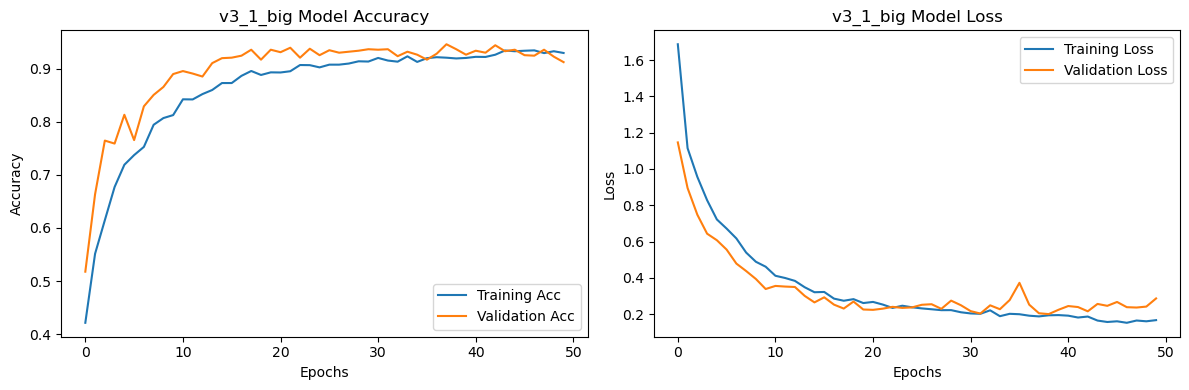

In [ ]:
# 3. 繪製訓練結果圖表
plt.figure(figsize=(12, 4))

# 準確率圖 (Accuracy)
plt.subplot(1, 2, 1)
plt.plot(history_v3_1_multi.history['accuracy'], label='Training Acc')
plt.plot(history_v3_1_multi.history['val_accuracy'], label='Validation Acc')
plt.title('v3_1_multi Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# 損失圖 (Loss)
plt.subplot(1, 2, 2)
plt.plot(history_v3_1_multi.history['loss'], label='Training Loss')
plt.plot(history_v3_1_multi.history['val_loss'], label='Validation Loss')
plt.title('v3_1_multi Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### 第五部分：Confusion Matrix

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
混淆矩陣圖表已儲存為 confusion_matrix_v3_multi.png


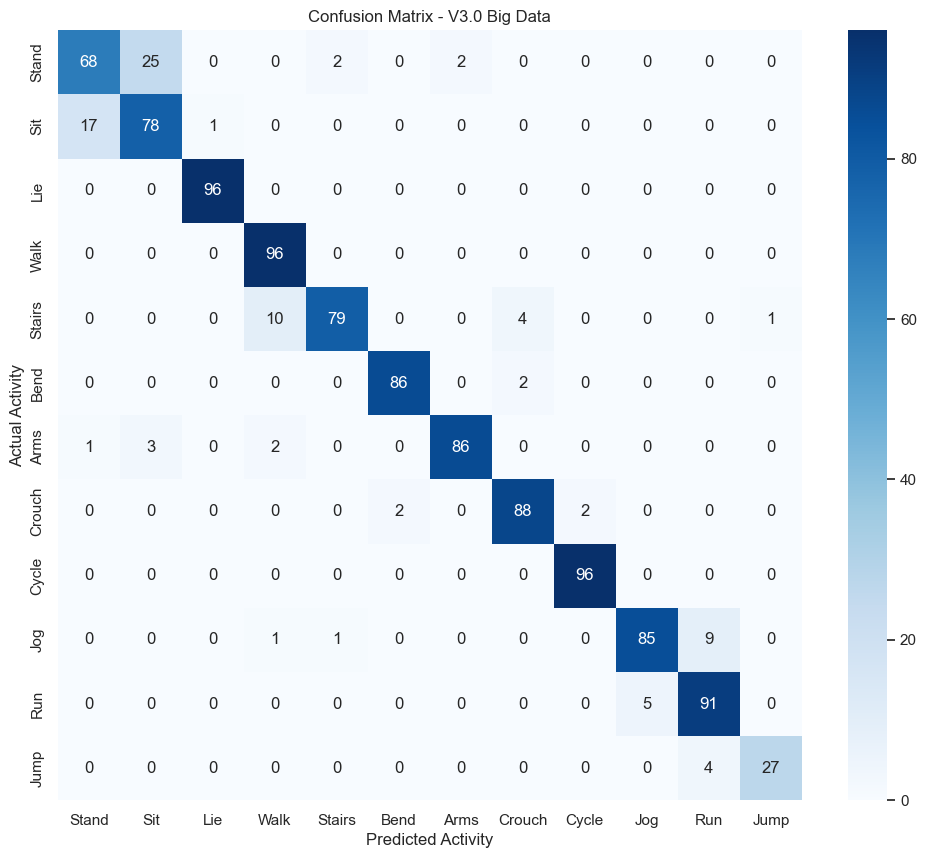

In [ ]:
# 1.　取得模型的預測結果，這裡會對驗證集 X_val 進行預測，並用 argmax 找出機率最高的標籤
y_pred_probs = brain_v3_1.predict(X_val)
y_pred = np.argmax(y_pred_probs, axis = 1)

# 2. 計算混淆矩陣，指定標籤範圍為 1 到 12，對應 MHEALTH 的 12 種有效動作
cm = confusion_matrix(y_val, y_pred, labels=range(1, 13))

#3. 定義動作名稱清單（供圖表標籤使用）
action_names = [
'Stand', 'Sit', 'Lie', 'Walk', 'Stairs',
'Bend', 'Arms', 'Crouch', 'Cycle',
'Jog', 'Run', 'Jump'

]
# 4. 繪製熱圖 (Heatmap)，注意：為了符合規範，不使用 .figure()，直接使用 sns 繪圖並儲存
sns.set(rc = {'figure.figsize':(12, 10)})
sns.heatmap(cm, annot = True, fmt='d', cmap=  'Blues',
xticklabels=action_names, yticklabels = action_names)
plt.title('Confusion Matrix - V3.0 Big Data')
plt.ylabel('Actual Activity')
plt.xlabel('Predicted Activity')

# 5. 儲存結果圖檔
plt.savefig('confusion_matrix_v3_1_multi.png')
print("混淆矩陣圖表已儲存為 confusion_matrix_v3_multi.png")